## Logistic Regression Model

Multinomial Logistic Regression: 3 outcomes
- patient is readmitted after 30 days
- patient is readmitted during 30 days
- patient is readmitted status is unknown
### Use softmax

#### Get X and y data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

seed = 1234

# Load dataset
df = pd.read_csv('../data/diabetic_data_cleaned.csv')

# Drop unique identifiers
df = df.drop(columns=['encounter_id', 'patient_nbr'])


# Define target variable
# multi
y_mult = df['readmitted'].map({'<30': 1, '>30': 0, 'NO': 2})

# binary
#  y_bin = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
y_bin = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Define features
X = df.drop(columns=['readmitted'])

categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Frequency Encoding
for col in categorical_columns: 
    freq_map = X[col].value_counts(normalize=True) 
    X[col] = X[col].map(freq_map)  
    
X_tr, X_te, y_tr_bin, y_te_bin = train_test_split(X, y_bin, test_size=0.2, random_state=seed)
X_tr, X_te, y_tr_mult, y_te_mult = train_test_split(X, y_mult, test_size=0.2, random_state=seed)

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

### Varies along number of training examples

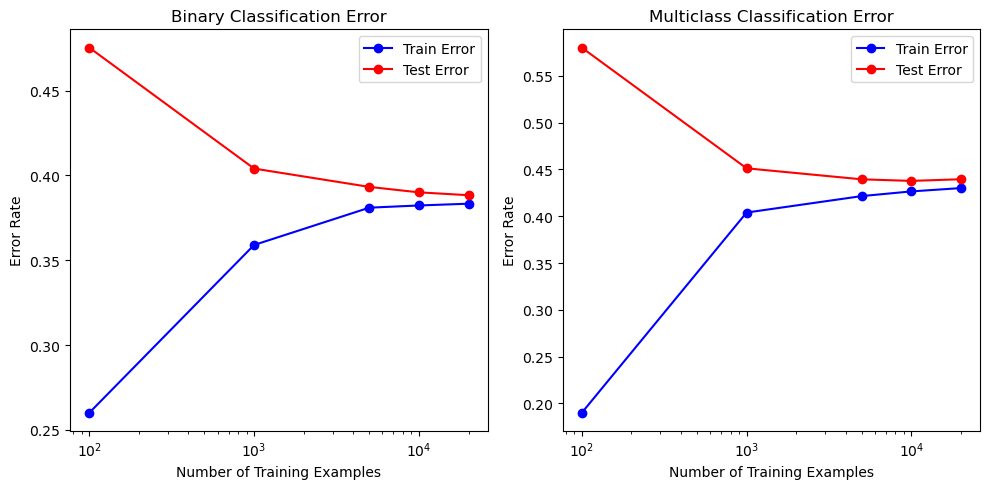

Best m for Binary Classification:  20000
Best m for Multiclass Classification:  10000


In [7]:
train_sizes = [100, 1000, 5000, 10000, 20000, ] #50000, 90000]
C = np.inf
# Initialize error lists
bin_train_errors, bin_test_errors = [], []
mult_train_errors, mult_test_errors = [], []

# Train Logistic Regression models for each data size
for m in train_sizes:
    Xm_train = X_tr[:m]
    ym_train_bin = y_tr_bin[:m]
    ym_train_mult = y_tr_mult[:m]
    
    # Binary Logistic Regression
    binary_model = LogisticRegression(random_state=seed, C=C, max_iter=10000)
    binary_model.fit(Xm_train, ym_train_bin)
    
    # Multiclass Logistic Regression
    multi_model = LogisticRegression(solver='lbfgs', random_state=seed, C=C, max_iter=10000)
    multi_model.fit(Xm_train, ym_train_mult)
    
    # Compute training errors
    bin_train_errors.append(np.mean(binary_model.predict(Xm_train) != ym_train_bin))
    mult_train_errors.append(np.mean(multi_model.predict(Xm_train) != ym_train_mult))
    
    # Compute test errors
    bin_test_errors.append(np.mean(binary_model.predict(X_te) != y_te_bin))
    mult_test_errors.append(np.mean(multi_model.predict(X_te) != y_te_mult))

# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Binary Classification
ax[0].semilogx(train_sizes, bin_train_errors, 'b-o', label='Train Error')
ax[0].semilogx(train_sizes, bin_test_errors, 'r-o', label='Test Error')
ax[0].set_xlabel('Number of Training Examples')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Binary Classification Error')
ax[0].legend()

# Multiclass Classification
ax[1].semilogx(train_sizes, mult_train_errors, 'b-o', label='Train Error')
ax[1].semilogx(train_sizes, mult_test_errors, 'r-o', label='Test Error')
ax[1].set_xlabel('Number of Training Examples')
ax[1].set_ylabel('Error Rate')
ax[1].set_title('Multiclass Classification Error')
ax[1].legend()

plt.tight_layout()
plt.show()

# Find the best C for each classification type
best_m_bin = train_sizes[np.argmin(bin_test_errors)]
best_m_mult = train_sizes[np.argmin(mult_test_errors)]

print('Best m for Binary Classification: ', best_m_bin)
print('Best m for Multiclass Classification: ', best_m_mult)

### Regulization strength

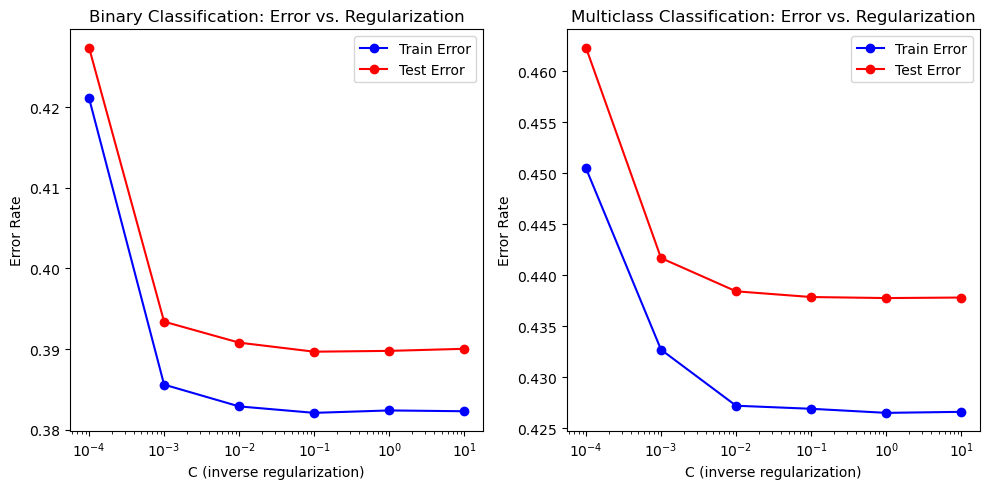

Best C for Binary Classification:  0.1
Best C for Multiclass Classification:  1.0


In [8]:
m_tr = 10000
C_vals = [.0001, .001, .01, .1, 1., 10.]
seed = 1234  

# Create lists to store errors
bin_train_errors, bin_test_errors = [], []
mult_train_errors, mult_test_errors = [], []  # Fixed the initialization

# Use a subset of 10,000 training samples
X_tr_subset, y_tr_bin_subset, y_tr_mult_subset = X_tr[:m_tr, :], y_tr_bin[:m_tr], y_tr_mult[:m_tr]

for C in C_vals:
    # Binary Logistic Regression
    bin_model = LogisticRegression(random_state=seed, C=C, max_iter=10000)
    bin_model.fit(X_tr_subset, y_tr_bin_subset)

    # Multiclass Logistic Regression
    mult_model = LogisticRegression(solver='lbfgs', random_state=seed, C=C, max_iter=10000)
    mult_model.fit(X_tr_subset, y_tr_mult_subset)
    
    # Compute training errors
    bin_train_errors.append(np.mean(bin_model.predict(X_tr_subset) != y_tr_bin_subset))
    mult_train_errors.append(np.mean(mult_model.predict(X_tr_subset) != y_tr_mult_subset))
    
    # Compute test errors
    bin_test_errors.append(np.mean(bin_model.predict(X_te) != y_te_bin))
    mult_test_errors.append(np.mean(mult_model.predict(X_te) != y_te_mult))

# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Binary Classification
ax[0].semilogx(C_vals, bin_train_errors, 'b-o', label='Train Error')
ax[0].semilogx(C_vals, bin_test_errors, 'r-o', label='Test Error')
ax[0].set_xlabel('C (inverse regularization)')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Binary Classification: Error vs. Regularization')
ax[0].legend()

# Multiclass Classification
ax[1].semilogx(C_vals, mult_train_errors, 'b-o', label='Train Error')
ax[1].semilogx(C_vals, mult_test_errors, 'r-o', label='Test Error')
ax[1].set_xlabel('C (inverse regularization)')
ax[1].set_ylabel('Error Rate')
ax[1].set_title('Multiclass Classification: Error vs. Regularization')
ax[1].legend()

plt.tight_layout()
plt.show()

# Find the best C for each classification type
best_C_bin = C_vals[np.argmin(bin_test_errors)]
best_C_mult = C_vals[np.argmin(mult_test_errors)]

print('Best C for Binary Classification: ', best_C_bin)
print('Best C for Multiclass Classification: ', best_C_mult)

In [10]:
model = LogisticRegression(random_state=seed, C=0.0001, max_iter=10000)
model.fit(X_tr_subset, y_tr_bin_subset)
y_tr_pred = model.predict(X_tr_subset)
train_error = np.mean(y_tr_pred != y_tr_bin_subset)
y_te_pred = model.predict(X_te)
test_error = np.mean(y_te_pred != y_te_bin)
print('Best error rate for binary target: ', test_error)

model = LogisticRegression(solver='lbfgs', random_state=seed, C=1, max_iter=10000)
model.fit(X_tr_subset, y_tr_mult_subset)
# Compute the training and test error rates at each value of C
y_tr_pred = model.predict(X_tr_subset)
train_error = np.mean(y_tr_pred != y_tr_mult_subset)
y_te_pred = model.predict(X_te)
test_error = np.mean(y_te_pred != y_te_mult)
print('Best error rate for multinomial target: ', test_error)

Best error rate for binary target:  0.4273621946866554
Best error rate for multinomial target:  0.43776451991229415


Best error rate for binary target: 0.115, 11.5%   

Best error rate for binary target: 0.438, 43.8%   